In [2]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Using TensorFlow backend.


In [3]:
input_shape = (224, 224)
categories_num = 37
batch_size = 32

Создадим генератор для обучения автокодировщика. Возьмем только 1/3 часть нашей тренировочной базы. 

In [4]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path']).iloc[::3]
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path']).iloc[::3]

train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        class_mode='input',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        class_mode='input',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 2145 validated image filenames.
Found 111 validated image filenames.


In [5]:
def plot_history(histories, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    for i in range(len(histories)):
        plt.plot(histories[i].history['categorical_accuracy'])
        plt.plot(histories[i].history['val_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'])
        plt.plot(histories[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

Возьмем метод для генерации модели из предыдущей работы. Добавим в модель декодировщик.

In [6]:
from keras import Sequential
from keras.layers import *
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils import plot_model

def conv_model(size=1, lr=0.001, use_dropout=False, use_batchnorm=False, use_globalpool=False, build_auto=False):
    model = Sequential()
    image_inputs = Input(shape=(input_shape[0], input_shape[1], 3,))
    
    model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='same',
                     input_shape=(input_shape[0], input_shape[1], 3,)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(MaxPooling2D((2, 2)))
    
    for i in range(size-1):
        model.add(Conv2D(128*(2**i), (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
                      
        model.add(Conv2D(128*(2**i), (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
                      
        model.add(MaxPooling2D((2, 2)))
    
    for i in range(size-1):    
        model.add(Conv2D(128//(2**i), (3, 3), padding='same', name=f'middle_{i}'))
        model.add(BatchNormalization())
        model.add(ReLU())
                      
        model.add(Conv2D(128//(2**i), (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        
        model.add(Conv2DTranspose(128//(2**i), (3, 3), strides=(2, 2), padding="same"))
        model.add(BatchNormalization())
        model.add(ReLU())
        
    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dropout(0.4))
        
    model.add(Conv2DTranspose(3, (3, 3), strides=(2, 2), padding="same", activation='sigmoid'))
        
    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

In [29]:
model = conv_model(size=3, lr=0.001, use_dropout=True, use_batchnorm=True, use_globalpool=True, build_auto=True)
model.summary()

plot_model(model, to_file='model_auto.png', show_shapes=True, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_25 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_25 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_26 (Batc (None, 56, 56, 128)       512       
_________________________________________________________________
re_lu_26 (ReLU)              (None, 56, 56, 128)       0         
__________

In [31]:
history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=1)

Epoch 1/10
67/67 [==============================] - 10s 153ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 2/10
67/67 [==============================] - 10s 155ms/step - loss: 0.0103 - val_loss: 0.0168
Epoch 3/10
67/67 [==============================] - 10s 153ms/step - loss: 0.0092 - val_loss: 0.0107
Epoch 4/10
67/67 [==============================] - 10s 149ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 5/10
67/67 [==============================] - 10s 156ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 6/10
67/67 [==============================] - 10s 156ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/10
67/67 [==============================] - 10s 154ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 8/10
67/67 [==============================] - 10s 154ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 9/10
67/67 [==============================] - 10s 154ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 10/10
67/67 [==============================] - 10s 156ms/step - loss: 0.0097 - val_lo

Ошибка упала до 0,0092 и больше не двигается. Проверим результат на тестовой выборке.

In [32]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='.',
        x_col='Path',
        class_mode='input',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames.


In [33]:
history_1 = model.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

print(f'test loss: {history_1}')

10/10 [==============================] - 1s 90ms/step
test loss: 0.008817542484030128


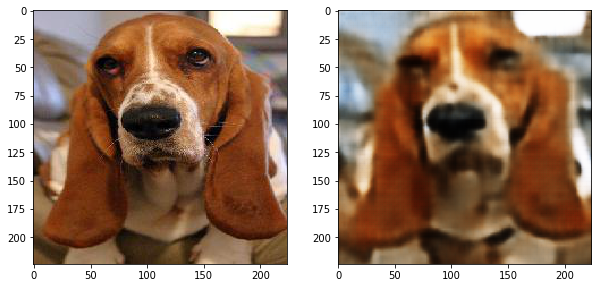

In [35]:
sample = test_generator.next()
image_array = sample[0]

predictions = model.predict(image_array)[0]

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(10)

axes[0].imshow(image_array[0])
axes[1].imshow(predictions)

plt.show()

Как видно автокодировщик попытался выделить на изображении главные части, которые могут повлиять на дальнейшую классификацию.

Уберем из модели часть декодера и вставим наш классификатор из предыдущей работы.

In [40]:
def build_model(auto_model, lr=0.001):
    model = Sequential()
    
    for layer in auto_model.layers:
        if 'middle' in layer.name:
            break
        model.add(layer)
        
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.7))
    
    model.add(Dense(units=categories_num, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [47]:
conv_model = build_model(model)
conv_model.summary()

W1218 16:18:46.176224 139975836014400 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_25 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_25 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_26 (Batc (None, 56, 56, 128)       512       
_________________________________________________________________
re_lu_26 (ReLU)              (None, 56, 56, 128)       0         
__________

Обучим получившуюся модель с проинициализированными весами. При этом будем применять аугментацию данных.

In [48]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=10,
        zoom_range=0.1,
        brightness_range=(0.7, 1.3),
        horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 6434 validated image filenames belonging to 37 classes.
Found 333 validated image filenames belonging to 37 classes.


Epoch 1/100
 - 141s - loss: 3.1220 - categorical_accuracy: 0.1569 - val_loss: 2.4652 - val_categorical_accuracy: 0.3469
Epoch 2/100
 - 139s - loss: 2.2697 - categorical_accuracy: 0.3503 - val_loss: 2.3125 - val_categorical_accuracy: 0.3322
Epoch 3/100
 - 138s - loss: 1.9718 - categorical_accuracy: 0.4182 - val_loss: 1.9305 - val_categorical_accuracy: 0.4518
Epoch 4/100
 - 134s - loss: 1.8118 - categorical_accuracy: 0.4587 - val_loss: 2.2877 - val_categorical_accuracy: 0.3455
Epoch 5/100
 - 120s - loss: 1.7110 - categorical_accuracy: 0.4845 - val_loss: 1.8610 - val_categorical_accuracy: 0.4651
Epoch 6/100
 - 111s - loss: 1.6059 - categorical_accuracy: 0.5193 - val_loss: 2.1106 - val_categorical_accuracy: 0.3754
Epoch 7/100
 - 111s - loss: 1.5024 - categorical_accuracy: 0.5507 - val_loss: 1.7755 - val_categorical_accuracy: 0.5249
Epoch 8/100
 - 111s - loss: 1.4595 - categorical_accuracy: 0.5647 - val_loss: 1.6020 - val_categorical_accuracy: 0.5183
Epoch 9/100
 - 116s - loss: 1.4126 - cat

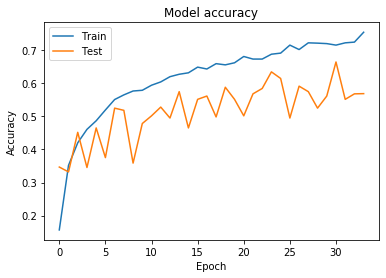

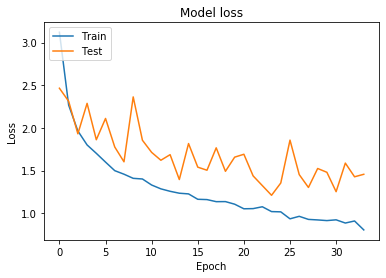

In [49]:
early_stop = EarlyStopping(patience=10)

history_2 = conv_model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

Ошибка и точность модели никак не изменились. Но изменилось колучиство эпох для достижения таких же результатов. 34 эпохи против 66 в предыдущей работе.

Попробуем так же уменьшить learnnig rate в надежде на большую сходимость к минимуму.

In [60]:
conv_model.optimizer = Adam(lr=0.00001)

Epoch 1/10
 - 113s - loss: 0.5781 - categorical_accuracy: 0.8229 - val_loss: 1.4977 - val_categorical_accuracy: 0.5748
Epoch 2/10
 - 111s - loss: 0.5963 - categorical_accuracy: 0.8128 - val_loss: 1.6949 - val_categorical_accuracy: 0.5249
Epoch 3/10
 - 111s - loss: 0.6723 - categorical_accuracy: 0.7932 - val_loss: 1.3793 - val_categorical_accuracy: 0.6113
Epoch 4/10
 - 111s - loss: 0.6208 - categorical_accuracy: 0.8111 - val_loss: 1.2694 - val_categorical_accuracy: 0.6279
Epoch 5/10
 - 110s - loss: 0.6126 - categorical_accuracy: 0.8063 - val_loss: 1.4492 - val_categorical_accuracy: 0.5714
Epoch 6/10
 - 113s - loss: 0.5678 - categorical_accuracy: 0.8270 - val_loss: 1.1761 - val_categorical_accuracy: 0.6678
Epoch 7/10
 - 111s - loss: 0.5667 - categorical_accuracy: 0.8249 - val_loss: 1.2264 - val_categorical_accuracy: 0.6578
Epoch 8/10
 - 111s - loss: 0.6471 - categorical_accuracy: 0.8002 - val_loss: 1.2440 - val_categorical_accuracy: 0.6279
Epoch 9/10
 - 111s - loss: 0.6851 - categorical_

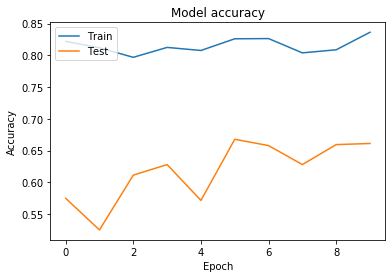

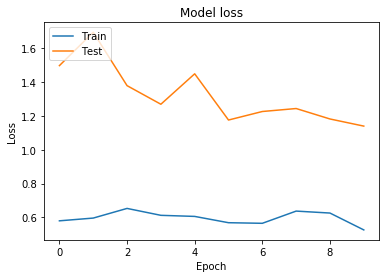

In [54]:
early_stop = EarlyStopping(patience=10)

history_2 = conv_model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

Опять же совершенно аналогичные результаты, за исключением количества эпох.

Получились неплохие результаты с учетом того, что время на обучение модели потребовалось в 2 раза меньше. К увеличению точности, к сожалению, это не привело.

In [58]:
conv_model.save('conv+auto+augdata.h5')

### Тестирование

In [62]:
best_model_1 = load_model('conv+auto+augdata.h5')

In [63]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames belonging to 37 classes.


In [76]:
history_1 = best_model_1.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

print(f' - test loss: {history_1[0]}, test accuracy: {history_1[1]}')

10/10 [==============================] - 1s 68ms/step
 - test loss: 1.2430409238584017, test accuracy: 0.6544850508239974


Original: Bombay
 - Bombay 0.99999905
 - scottish_terrier 9.241556e-07
 - Siamese 1.5148202e-09


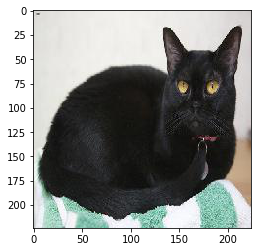

In [86]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions_1 = best_model_1.predict(image_array)[0]

best_args_1 = np.argsort(predictions_1)[::-1][:3]

print(f'Original: {category}')
for i in best_args_1:
    print(' -', categories_dict[i], predictions_1[i])

plt.imshow(image_array[0])